In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [51]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5) * (1.0 + np.sin(2 * step / self.warmup) ** 2), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

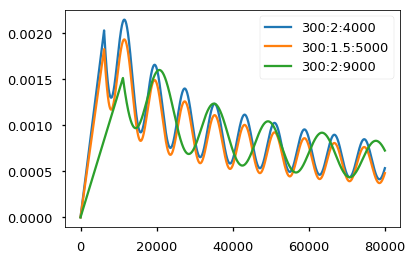

In [55]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(300, 2, 5000, None), 
        NoamOpt(300, 1.8, 5000, None),
        NoamOpt(300, 2, 9000, None)]
plt.plot(np.arange(1, 80000), [[opt.rate(i) for opt in opts] for i in range(1, 80000)])
plt.legend(["300:2:4000", "300:1.5:5000", "300:2:9000"])
None

In [13]:
class TriangleOpt:
    "Optim wrapper that implements rate."
    def __init__(self, base_lr, max_lr, step_size, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.step_size = step_size
        self.base_lr = base_lr
        self.max_lr = max_lr
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `triangle rate` above"
        if step is None:
            step = self._step
        cycle = np.floor(1+step/(2*self.step_size))
        x = np.abs(step/self.step_size - 2*cycle + 1)
        lr = self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))/float(2**(cycle-1))
        return lr
        
def get_std_opt(model):
    return TriangleOpt(0.0001, 0.001, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

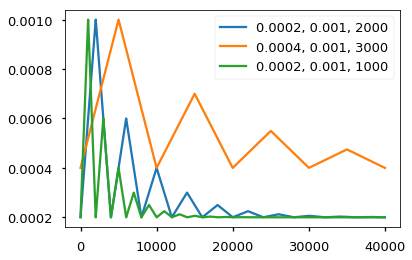

In [20]:
# Three settings of the lrate hyperparameters.
opts = [TriangleOpt(0.0002, 0.001, 2000, None), 
        TriangleOpt(0.0004, 0.001, 5000, None),
        TriangleOpt(0.0002, 0.001, 1000, None)]
plt.plot(np.arange(1, 40000), [[opt.rate(i) for opt in opts] for i in range(1, 40000)])
plt.legend(["0.0002, 0.001, 2000", "0.0004, 0.001, 3000", "0.0002, 0.001, 1000"])
None